# XGBoost

- [docs](https://xgboost.readthedocs.io/en/stable/#)

In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## 1. Data Load

In [2]:
data_dir = './data/'
csv_file_path = os.path.join(data_dir, 'train_data.csv') 
df = pd.read_csv(csv_file_path)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


## 2. Feature Engineering

In [3]:
import pandas as pd

def feature_engineering(df):

    # 유저별로 정렬
    df.sort_values(by=['userID', 'Timestamp'], inplace=True)
    
    # 데이터 타입 변경
    dtype = {
        'userID': 'int16',
        'answerCode': 'int8',
        'KnowledgeTag': 'int16'
    }
    df = df.astype(dtype)
    
    # 'Timestamp' 열을 날짜/시간 형식으로 파싱
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')

    # testTag 추가
    df['testTag'] = df['testId'].apply(lambda x: x[2]).astype('int16')

    # 유저별로 정답 누적 횟수 계산, 결측치 0
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_correct_answer'].fillna(0, inplace=True)
    
    # 유저별로 제출 누적 횟수 계산
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount() 
    
    # 유저별로 누적 정답률 계산, 결측치 0.75
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    df['user_acc'].fillna(0.75, inplace=True)

    # userID별 정답률 추가
    df['user_sum'] = df.groupby('userID')['answerCode'].transform('sum')
    df['user_mean'] = df.groupby('userID')['answerCode'].transform('mean')
    
    # assessmentItemID별 정답률 추가
    df['assessment_sum'] = df.groupby('assessmentItemID')['answerCode'].transform('sum')
    df['assessment_mean'] = df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
    # testId별 정답률 추가
    df['test_sum'] = df.groupby('testId')['answerCode'].transform('sum')
    df['test_mean'] = df.groupby('testId')['answerCode'].transform('mean')
    
    # KnowledgeTag별 정답률 추가
    df['knowledgeTag_sum'] = df.groupby('KnowledgeTag')['answerCode'].transform('sum')
    df['knowledgeTag_mean'] = df.groupby('KnowledgeTag')['answerCode'].transform('mean')
    
    # testTag별 정답률 추가
    df['testTag_sum'] = df.groupby('testTag')['answerCode'].transform('sum')
    df['testTag_mean'] = df.groupby('testTag')['answerCode'].transform('mean')

    # 상대적 정답률
    df['relative_answer_assessment'] = df['answerCode'] - df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
    # 유저별 상대적 정답률 평균 - 학습 수준 레벨
    df['relative_answer_mean'] = df.groupby('userID')['relative_answer_assessment'].transform('mean')

    # 유저가 문항을 푼 시간
    df['time_to_solve'] = df.groupby(['userID', 'testId'])['Timestamp'].diff().dt.total_seconds().shift(-1)
    
    # 결측치 이전 행의 값으로 채움
    df['time_to_solve'].fillna(method='ffill', inplace=True)

    # 유저별 문항 시간 평균
    #df['time_to_solve_mean'] = df.groupby('userID')['time_to_solve'].transform('mean')
    df['time_to_solve_mean'] = df.groupby(['userID', 'testId'])['time_to_solve'].transform('mean')

    # clip(0, 255)는 메모리를 위해 uint8 데이터 타입을 쓰기 위함
    df['prior_assessment_frequency'] = df.groupby(['userID', 'assessmentItemID']).cumcount().clip(0, 255)

    # 각 태그별로 이전에 몇번 풀었는지
    df['prior_KnowledgeTag_frequency'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()
    
    # 시험지 태그별 학년별 몇번 풀었는지
    df['prior_testTag_frequency'] = df.groupby(['userID', 'testTag']).cumcount()
    
    return df


In [4]:
df = feature_engineering(df)
df.head()

/var/folders/8r/strv9f_x6b3ghnb0chcl145m0000gn/T/ipykernel_2741/21048499.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_to_solve'].fillna(method='ffill', inplace=True)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testTag,user_correct_answer,user_total_answer,user_acc,...,knowledgeTag_mean,testTag_sum,testTag_mean,relative_answer_assessment,relative_answer_mean,time_to_solve,time_to_solve_mean,prior_assessment_frequency,prior_KnowledgeTag_frequency,prior_testTag_frequency
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,0.0,0,0.75,...,0.955022,187545,0.709232,0.017937,-0.025899,3.0,7.833333,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,1.0,1,1.00,...,0.913187,187545,0.709232,0.035874,-0.025899,8.0,7.833333,0,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,2.0,2,1.00,...,0.913187,187545,0.709232,0.089686,-0.025899,7.0,7.833333,0,1,2
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,3.0,3,1.00,...,0.913187,187545,0.709232,0.031390,-0.025899,7.0,7.833333,0,2,3
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,4.0,4,1.00,...,0.913187,187545,0.709232,0.058296,-0.025899,11.0,7.833333,0,3,4


## 3. Train/Test 데이터 셋 분리

In [5]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)

def custom_train_test_split(df, ratio=0.7, split=True):
    # df: 입력 데이터프레임
    # ratio: 학습 데이터의 비율, 기본값은 0.7
    # split: True로 설정할 경우 테스트 데이터를 반환, False로 설정할 경우 학습 데이터를 반환

    # 사용자(UserID) 아이디와 해당 유저의 데이터 개수를 튜플로 묶어 리스트로 만듭니다.
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    
    # 유저 리스트를 무작위로 shuffle
    random.shuffle(users)

    # 학습용 데이터의 최대 길이를 계산(ratio), 1586610.2
    max_train_data_len = ratio*len(df) 

    # 학습용 데이터의 누적 개수와 학습에 사용할 유저 아이디를 저장할 변수 초기화
    sum_of_train_data = 0   # 1586711

    # 학습에 사용할 user_id 를 리스트에 추가
    user_ids =[]            # 4669 유저
    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data: # 학습 데이터의 누적 개수가 최대 길이를 초과하면 루프를 종료
            break
        user_ids.append(user_id) 

    # 학습용 데이터로 사용할 user_id 에 해당하는 데이터를 선택하여 train에 할당 합니다.
    train = df[df['userID'].isin(user_ids)]

    # 테스트 데이터로 사용할 user_id 에 해당하는 데이터를 선택하여 test에 할당합니다.
    test = df[df['userID'].isin(user_ids) == False]
    
    # test 데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [6]:
train, test = custom_train_test_split(df)

In [7]:
df.columns.tolist()

['userID',
 'assessmentItemID',
 'testId',
 'answerCode',
 'Timestamp',
 'KnowledgeTag',
 'testTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
 'user_sum',
 'user_mean',
 'assessment_sum',
 'assessment_mean',
 'test_sum',
 'test_mean',
 'knowledgeTag_sum',
 'knowledgeTag_mean',
 'testTag_sum',
 'testTag_mean',
 'relative_answer_assessment',
 'relative_answer_mean',
 'time_to_solve',
 'time_to_solve_mean',
 'prior_assessment_frequency',
 'prior_KnowledgeTag_frequency',
 'prior_testTag_frequency']

## 4. Feature Selection

In [8]:
# 피쳐 13개 

FEATS = [
 'KnowledgeTag',
 'testTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
#  'user_sum',
 'user_mean',
#  'assessment_sum',
 'assessment_mean',
#  'test_sum',
 'test_mean',
#  'knowledgeTag_sum',
 'knowledgeTag_mean',
#  'testTag_sum',
#  'testTag_mean',
 #'relative_answer_assessment',
 'relative_answer_mean',
 'time_to_solve', 
 'time_to_solve_mean',
#  'prior_assessment_frequency',
#  'prior_KnowledgeTag_frequency',
 'prior_testTag_frequency'
 ]

In [9]:
# X, y 값 분리 피쳐들, answerCode
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

# 훈련 데이터와 테스트 데이터를 나누는 부분
X_train = train[FEATS]
X_test = test[FEATS]

# XGBoost 데이터 형태로 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## 4. 훈련 및 검증

In [10]:
# XGBoost 모델 파라미터 설정
params = {
    'objective': 'binary:logistic',  # 이진 분류 문제
    'eval_metric': 'auc',            # 평가 지표
    'max_depth': 6,                  # 트리의 최대 깊이
    'eta': 0.1,                      # 학습률
    'subsample': 0.8,                # 훈련 데이터 샘플링 비율
    'colsample_bytree': 0.8,         # 각 트리마다 사용되는 특성의 비율
    'min_child_weight': 1,           # 리프 노드의 최소 가중치 합
    'gamma': 0.1                     # 리프 노드의 가중치를 더할지 결정하는 파라미터
}

# XGBoost 모델 훈련
num_round = 500  # 훈련 라운드 수
bst = xgb.train(params, dtrain, num_round, [(dtrain, 'train'), (dtest, 'test')])

# 테스트 데이터에 대한 예측
preds = bst.predict(dtest)

# 정확도 및 AUC 평가
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC: {auc} ACC: {acc}\n')

/Users/daeheehan/anaconda3/envs/dkt/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.81994	test-auc:0.77861
[1]	train-auc:0.82919	test-auc:0.79273
[2]	train-auc:0.82778	test-auc:0.78982
[3]	train-auc:0.83017	test-auc:0.79544
[4]	train-auc:0.82814	test-auc:0.79216
[5]	train-auc:0.83035	test-auc:0.79559
[6]	train-auc:0.83155	test-auc:0.79686
[7]	train-auc:0.83252	test-auc:0.79782
[8]	train-auc:0.83324	test-auc:0.79879
[9]	train-auc:0.83316	test-auc:0.79767
[10]	train-auc:0.83379	test-auc:0.79811
[11]	train-auc:0.83357	test-auc:0.79751
[12]	train-auc:0.83422	test-auc:0.79834
[13]	train-auc:0.83414	test-auc:0.79784
[14]	train-auc:0.83396	test-auc:0.79747
[15]	train-auc:0.83484	test-auc:0.79902
[16]	train-auc:0.83544	test-auc:0.79939
[17]	train-auc:0.83596	test-auc:0.80061
[18]	train-auc:0.83655	test-auc:0.80154
[19]	train-auc:0.83685	test-auc:0.80217
[20]	train-auc:0.83712	test-auc:0.80276
[21]	train-auc:0.83738	test-auc:0.80335
[22]	train-auc:0.83766	test-auc:0.80354
[23]	train-auc:0.83790	test-auc:0.80412
[24]	train-auc:0.83820	test-auc:0.80438
[25]	train

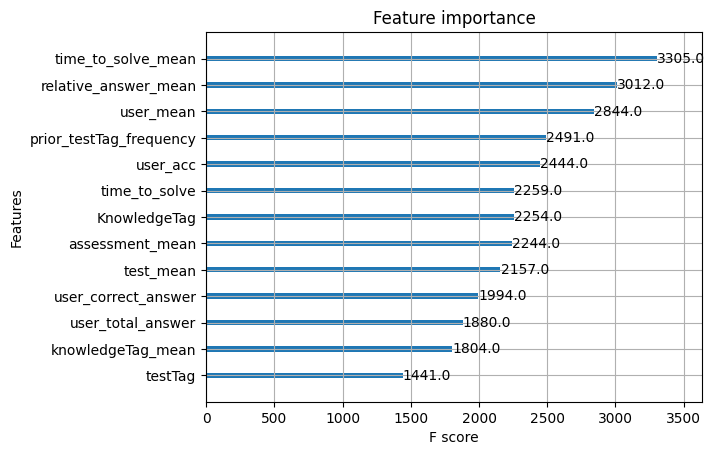

In [11]:
_ = xgb.plot_importance(bst)

## 5. Inference

In [12]:
# LOAD TESTDATA
data_dir = './data/'
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

# 테스트 데이터에 대한 예측
total_preds = bst.predict(xgb.DMatrix(test_df[FEATS]))

/var/folders/8r/strv9f_x6b3ghnb0chcl145m0000gn/T/ipykernel_2741/21048499.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_to_solve'].fillna(method='ffill', inplace=True)


In [13]:
# 결과를 파일로 저장
output_dir = 'output_XGBoost/'
write_path = os.path.join(output_dir, "submission_XGBoost_f13.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction: {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id, p))

writing prediction: output_XGBoost/submission_XGBoost_f13.csv
